# Mini Project 3
## Bike paths and accidents

**Names:** Enrique Sanchez, Parker Addison

> You can jump to my favorite section [here](#favorite-section).

Are you more or less likely to face injurity in a bike-related accident if that accident occurs on a bike path or not?  What if you look at this dependent on severity, zipcode, or type of parties involved?  Where in the city of San Diego are you more likely to get into an accident involving alcohol?  Can this be explained by additional statistics by zipcode, such as the number of bars in a zipcode?

We can answer all of these questions, and more, by using the ArcGIS API for Python.

Remember that in the first lecture we found a layer containing collisions and bike routes.  This file showed bike and pedestrian TIMS-geocoded (Transpotation Injury Mapping System) collisions in San Diego county.  You can view the relevant metadata at https://tims.berkeley.edu/help/SWITRS.php (Statewide Integrated Traffic Records System from CA Highway Patrol)


Your tasks include:
1. At the site above, go to SWITRS Query and Map, then request bike collision data between 1/1/2014 and 12/31/2018 for San Diego city.
1. Download and explore the collision data.  Also download and explore party and victim data.
1. Explor and understand the fields you need to work with. See SWITRS FAQ page at https://tims.berkeley.edu/help/Query_and_Map.php#FAQs and the codebook at https://tims.berkeley.edu/help/SWITRS.php#Codebook. SWITRS is relatively well documented.
1. Find a way to join all three tables (collisions, parties, victims). Note that there are similarly-named fields in the three tables, but they can mean different things or be applied to different groups.
1. Create point map of collisions.
1. Save the joined table as a feature service on ArcGIS Online.
1. Identify collisions that happened on versus off of a bike path. This can be tricky. Geometrically, what does it mean to "be on a bike path"?  Also, which ArcGIS techniques can you use to connect Collisions to Bike Routes?
1. Summarize collision trends by zipcode, and use geoenrichment to add additional data to the zipcodes table.
1. Analyze the collisions and zipcode layers, answering the questions above.  Use a technique such as regression to build a model and/or further your analysis.

Deliverables:
1. Maps of bicycle accidents and bike paths, dependent on a) alcohol involvement, b) whether the ciclist was at fault due to impairment, and c) type of parties involved.
2. By zipcode, display accidents with alcohol involved as well as one other variable that may explain it based on your exploration.
3. A brief description of findings (300 words or more)
4. URLs for all resources you've added to ArcGIS Online
5. For extra credit: a) interesting exploration involving the victims table and b) insights that can be presented to a local planning commission to reduce the risk or severity of bike collisions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import arcgis
from arcgis.gis import GIS
from arcgis.features.find_locations import find_existing_locations
from arcgis.geoenrichment import standard_geography_query, enrich

import scipy
import sklearn

In [2]:
gis = GIS(username='pgaddiso_UCSDOnline8')

Enter password: ········


In [ ]:
# 1. Loading the data.

In [3]:
# Lets go ahead and read in the data.

# This is data from San Diego City.
collisions = pd.read_csv("data/Collisions.csv")
parties = pd.read_csv("data/Parties.csv")
victims = pd.read_csv("data/Victims.csv")

In [ ]:
# 2. Joining party (and victims for extra credit) to the collisions data

In [4]:
# In order to join these data frames together, we must find the columns they share
shared_collisions_parties = list(set(collisions.columns) & set(parties.columns))

# We can see that they all share two columns names: ACCIDENT_YEAR and CASE_ID
# We should note that when we join collisions and parties, CASE_ID will no longer be
# unique. We will have n similar CASE_IDs where n is the party size involved in collision.
collisions_parties = collisions.merge(parties, on=shared_collisions_parties)

# Since we now have party information and collision data together, we must merge it with
# victim data. However, we cannot merge only on CASE_ID since this will lead to 
# unwanted repetition. Instead, we should merge on CASE_ID and PARTY_NUMBER so we merge
# the correct victim information to the corresponding victim in the joint collisions above.
#
# Note that we're using a left join here because we have data for only a subset (~2700) of
# victims.  We don't want this to affect our analysis of the collisions, so we want to keep
# all of our collision entries!
shared_with_victims = list(set(collisions_parties.columns) & set(victims.columns))
all_data = collisions_parties.merge(victims, on=shared_with_victims, how="left")

In [ ]:
# 3. Cleaning spatial data and creating a point map of collisions.

In [5]:
# Our data has LONGITUDE and LATITUDE which are generated by GPS, as well as POINT_X and POINT_Y
# which have been geocoded already.
#
# We should fill in any missing lat-long with their point_x and point_y, since the lat-long are
# likely more accurate since they were generated at the scene.

# If we attempt to create a point layer for collisions as is, we will be unable 
# to plot as it is missing 355 coordinate pairs. Therefore, we should remove
# the rows that have the coordinates missing.

# Additionally, let's not confuse ourselves!  We'll drop the POINT_X, POINT_Y, LONGITUDE, and
# LATITUDE columns once we create the new columns.

def clean_coords(df):
    df_xy = (
        df
        .assign(
            x=all_data.LONGITUDE.combine_first(all_data.POINT_X),
            y=all_data.LATITUDE.combine_first(all_data.POINT_Y)
        )
        .drop(["POINT_X", "POINT_Y", "LONGITUDE", "LATITUDE"], axis=1)
        .dropna(subset=['x', 'y'])
    )
    
    return df_xy

collisions = clean_coords(collisions)

# Now that we have the coordinates in the right place, we will create a
# spatial data frame.
#
# For whatever reason, we won't be able to fully plot our sdf unless we drop
# additional columns.
#
# Note: This is an sdf of just the collisions.
sdf = (
    pd.DataFrame.spatial.from_xy(collisions, x_column = 'x', y_column='y')
    .replace(np.NaN, '', regex=True)
    .drop(["PCF_VIOLATION"], axis=1)
)
sdf = sdf.replace(np.nan, '', regex=True)

In [ ]:
# Now we can plot all collisions!
map1 = gis.map("San Diego", zoomlevel=10)
sdf.spatial.plot(map_widget=map1, alpha=.3)
map1

In [ ]:
# 4. Classifying on-path and off-path collisions and summarizing different collision types by zipcode.

In [6]:
# First we should get a hold of San Diego bike routes.
#
# Data description:
# """
# This dataset uses the SanGIS Roads_All layer as the basis for the linear
# features. SANDAG obtained input on bike network data from local jurisdictions
# in 2017 and 2018 and used this information to update the regional bikeways
# dataset. For specific information regarding the status of bike facilities
# represented in the data, please contact bike planning staff for the respective
# local jurisdictions.
#
# This data has been reprojected for purposes of the San Diego Ocean Planning
# Partnership, a collaborative pilot project between the California State Lands
# Commission and the Port of San Diego. For more information about the
# Partnership, please visit: https://www.sdoceanplanning.org/ These routes,
# while being well outside of the planning boundary, show conduits for coastal
# access from communities across San Diego. As with all data shown outside of
# the preliminary planning boundary, this data is included for reference only.
#
# This dataset is available for viewing in an interactive web map. Visit
# 511sd.com/bikemap to view the interactive map. 
# """
#
# Source:
# https://ucsdonline.maps.arcgis.com/home/item.html?id=086106add0a645ba864db08f45c795ea

bike_routes_fl = gis.content.get("086106add0a645ba864db08f45c795ea")

# Let's also read in our collision data from ArcGIS Online

# ---------------------------------------------------------------------------- #
# Exporting our collisions sdf to a feature layer.
#
# Note: This only needs to be run once.  It should be shared and accessible now!

# collisions_fl = sdf.spatial.to_featurelayer("MP3-BikeCollisions", gis, ["bike", "collisions"])
# collisions_fl.share(org=True)
# ---------------------------------------------------------------------------- #

collisions_fl = gis.content.get("17010ad85a8d43159bd786b34144b96e")


# After a bit of analysis, we determined that 40 feet is a pretty
# good estimate for the error between a true bike path and 
# bike collision.
#
# Many bike paths are drawn through the center of large roads such as Gilman or
# Genesee, as opposed to having a bike path for each direction.  These roads are
# often two to three lanes each direction, and thus there's an expected error of
# about ~24–36 feet between the median strip and a bike lane (side of road).
#
# It is also likely that locations are reported from the sidewalk, as opposed to
# the center of the road, so there may be additional error between the bike lane
# and the sidewalk where the incident was reported.
#
# Unfortunately, for narrower bike paths or roads, this buffer may be too large;
# perhaps we are capturing collisions that took place across the street...
#
# This is an issue that probably requires the use of different sized buffers
# around the different types of bike routes listed in our data source.  However,
# we don't quite have enough domain expertise in the field of bike paths to know
# what sort of bike routes there are, and what sort of buffers make sense.
#
# For the purpose of our analysis, what we currently have works fine!

# ---------------------------------------------------------------------------- #
# It should be noted that using `find_existing_locations` resulted in some bugs,
# in which some collisions would be selected when they shouldn't have, and vice
# versa.
#
# Additionally, `join_features` is preferred here so that we have access to the
# type of route that the collision took place on, which may be interesting for
# future analysis.

# Note: This only needs to be run once.  It should be shared and accessible now!

# path_collisions_fl = arcgis.join_features(
#     collisions_fl.layers[0], bike_routes_fl.layers[0], "withindistance", 40, "Feet",
#     output_name="MP3-PathCollisions"
# )
# path_collisions_fl.share(org=True)
# ---------------------------------------------------------------------------- #

path_collisions_fl = gis.content.get("199dffb82ba44d499e00a728a40403df")

In [ ]:
# Let's plot the data to verify the accuracy of on-path collisions.

# Multi colored lines: Bike paths
# Orange dots: Collision
# Blue dots: Collision on a bike path
map2 = gis.map("San Diego", zoomlevel=10)
map2.add_layer(path_collisions_fl)
map2.add_layer(bike_routes_fl, {'opacity':.6})
map2.add_layer(collisions_fl)
map2

In [7]:
# Let's convert the bike path collisions into a spatial data frame so that we can
# add a boolean to our collisions feature layer.
path_collisions_df = path_collisions_fl.layers[0].query().sdf

# Since path_collisions_df contains CASE_ID, we can add a boolean column to our
# original sdf that signifies whether or not the collision was on a bike path
on_path_bools = sdf.CASE_ID.isin(path_collisions_df.CASE_ID)


# Adding zip codes to our original sdf will be helpful for future analysis
# in determining exactly where these collisions are occurring.
#
# We decided to use a spatial join here, as reverse geocoding would have involved
# additional cleanup to extract the zipcode from the addresses, and could result
# in incorrect zipcodes if the bike path has no nearby addresses.

# Reading in zip code data
sd_zip_codes = gis.content.search('title: San Diego Zip Codes', outside_org=True)[0]
zip_codes = sd_zip_codes.layers[0]

# ---------------------------------------------------------------------------- #
# Spatial join between collision layer and this new layer
# join = arcgis.join_features(
#     collisions_fl, zip_codes, spatial_relationship='within',
#     output_name="MP3-CollisionsWithZipcodes"
# )
# join.share(org=True)
# ---------------------------------------------------------------------------- #

join = gis.content.get("0ca2a0a2ed054133a39271590ae90381")
collisions_zipcodes = join.layers[0].query().sdf


# Now we can add the zip codes and path booleans to sdf
collisions_sdf = (
    sdf.assign(
        ON_PATH=on_path_bools,
        ZIPCODE=collisions_zipcodes.ZIP,
    )
    .merge(path_collisions_df[["CASE_ID", "ROUTE"]], on="CASE_ID", how="left")
)

In [ ]:
# 5. Generating maps

In [8]:
# Some setup for the maps:

map_sdf = collisions_sdf.copy()

### For the alcohol question ###

# Let's clean the alcohol column in the sdf
map_sdf["ALCOHOL_INVOLVED"] = map_sdf["ALCOHOL_INVOLVED"].replace({'':"False", 'Y': "True"})


### For the impairment question ###

# Let's determine which cases involved bikers that were at fault and impaired

# NOTE: The PARTY_SOBRIETY column has many vlaues where the impairment in unknown.
# In order to not make false assumptions, we will only count impaired as those
# with the value 'B': Had been drinking, under influence
# Also, those who are under drug influence or physical impairment in PARTY_DRUG_PHYSICAL
impaired = collisions_parties[(collisions_parties['PARTY_TYPE'] == '4') & 
                              (collisions_parties['AT_FAULT'] == 'Y') &
                              ((collisions_parties['PARTY_SOBRIETY'].isin(['B'])) |
                               (collisions_parties['PARTY_DRUG_PHYSICAL'] == 'E') | 
                               (collisions_parties['PARTY_DRUG_PHYSICAL'] == 'F'))]

impaired_cases = impaired['CASE_ID'].unique()

# Lets now create a column in our sdf signifying whether the bicylcist
# was at fault and impaired
map_sdf['BIKE_IMPAIRED'] = map_sdf['CASE_ID'].isin(impaired_cases).astype(str)


### For the party question ###

# Let's figure out the different party combinations that we have
party_types = {
    '1': "Driver",
    '2': "Pedestrian",
    '3': "Parked Vehicle",
    '4': "Bicyclist",
    '5': "Other",
    '-': "Unknown"
}

party_combos = (
    collisions_parties
    .assign(PARTY_TYPE=collisions_parties.PARTY_TYPE.replace(party_types))
    .groupby('CASE_ID')
    .PARTY_TYPE
    .apply(lambda x: tuple(np.sort(x.tolist())))
)

combos_less_than_three = party_combos.value_counts().loc[lambda ser: ser < 3].index

party_combos[party_combos.isin(combos_less_than_three)] = "Other Combination"

map_sdf = map_sdf.merge(party_combos.astype(str).to_frame(), left_on="CASE_ID", right_index=True)

**1a.**
Let's begin by generating a map of bike collisions dependent on whether or not alcohol was involved.

In [9]:
print('Number of collisions where alcohol was involved: %d' %sum(map_sdf['ALCOHOL_INVOLVED'] == "True"))

Number of collisions where alcohol was involved: 183


In [ ]:
map3 = gis.map("San Diego", zoomlevel=10)
map3.add_layer(bike_routes_fl, {'opacity':0.3})
# Note that the color map is not fully deterministic...
# If the colors are too similar, running this cell again will likely fix the issue.
map_sdf.spatial.plot(map_widget=map3, renderer_type= 'u', col='ALCOHOL_INVOLVED', cmap='plasma')
map3.legend=True
map3

**1b.** 
Now we want a map dependent on whether the bicyclist was at fault due to impairment.

In [10]:
print('Number of collisions where bicyclist was at fault due to impairment: %d' %sum(map_sdf["BIKE_IMPAIRED"] == "True"))

Number of collisions where bicyclist was at fault due to impairment: 31


In [ ]:
map4 = gis.map("San Diego", zoomlevel=10)
# Note that the color map is not fully deterministic...
# If the colors are too similar, running this cell again will likely fix the issue.
map_sdf.spatial.plot(map_widget=map4, renderer_type='u', col='BIKE_IMPAIRED', cmap='plasma')
map4.add_layer(bike_routes_fl, {'opacity':.5})
map4.legend=True
map4

**1c.**
Lastly, we want a map of collisions dependent on the types of the other party.

In [ ]:
# Now we can plot!
map5 = gis.map("San Diego", zoomlevel=10)
# Note that the color map is not fully deterministic...
# If the colors are too similar, running this cell again will likely fix the issue.
map_sdf.spatial.plot(map_widget=map5, renderer_type='u', col="PARTY_TYPE", cmap="plasma")
map5.add_layer(bike_routes_fl, {'opacity':.5})
map5.legend=True
map5

In [ ]:
# 6. Analyze the data and respond to the above questions

**Are you more likely to be injured in a bike-related accident if it occurs on or off of a bike path?**

First and foremost, we should determine the proportion of bike collisions that occurred on bike paths.

In [11]:
prop_path = collisions_sdf.ON_PATH.mean()
print('Proportion of bike collisions on bike path: %f' %prop_path)

Proportion of bike collisions on bike path: 0.627083


In [12]:
# Let's make sure we're not looking at a case of Simpson's Paradox!
#
# If we group by zipcode, do we still see roughly the same proportion?
print(
    "Average proportion of on-path bike collisions when grouping by zipcode:",
    collisions_sdf.groupby("ZIPCODE").ON_PATH.mean().mean()
)

Average proportion of on-path bike collisions when grouping by zipcode: 0.6125254458867019


Over 60% of collisions occur on a path!  While this may sounds like being on a path is more dangerous than being off a path, it is actually inconclusive in either direction, since we don't have any idea how many cyclists ride on bike paths versus off of bike paths.  Thus, we have no way to find collisions *rates* for on-versus-off path.  We'll need to find another way to investigate this.

We can compare the the injury rates on and off bike paths.

TIMS provides some meta data on the collision severity column:

- 1 - Fatal
- 2 - Injury (Severe)
- 3 - Injury (Other Visible)
- 4 - Injury (Complaint of Pain)
- 0 – Property Damage Only (PDO)

We can consider any value between 1–4 as an injury.

In [13]:
# Let's compute the proportion of injuries for the collisions
# on and off the bike paths
collisions_sdf.groupby("ON_PATH")['COLLISION_SEVERITY'].apply(lambda x: sum(x > 0) / len(x))

ON_PATH
False    1.0
True     1.0
Name: COLLISION_SEVERITY, dtype: float64

Well, it appears that every collision (on or off a bike path) has resulted in some sort of injury. Therefore, based on the data, you are just as likely to be injured if you are on a bike path as off a bike path.

Of course, this is not interesting so we will compare the severity of the injuries on and off bike paths.

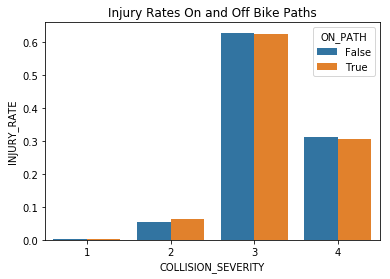

In [14]:
# We find the rate of each type of severity level.
injury_rates = collisions_sdf.groupby("ON_PATH")['COLLISION_SEVERITY'].value_counts(normalize=True).rename('INJURY_RATE')

sns.barplot(x='COLLISION_SEVERITY', y='INJURY_RATE', hue='ON_PATH', data = injury_rates.reset_index())
plt.title('Injury Rates On and Off Bike Paths');

The distributions of collision severities on and off bike paths appear identical. Although there are some differences, they are not extreme enough to convince us that the severity of injuries differ on and off bike paths.

**How would the results differ for injuries of different severity, by zipcodes, and by the type of other party in the accident?**

In the previous question, we analyzed the differences in severity between collisions on and off bike paths so we will now focus on zip codes and the types of the other party.

Zip codes can be quite interesting as some areas can have more people, more bike paths, etc. Let's quickly analyze the severity of the injuries within each zip code regardless of where the collision occurred. 

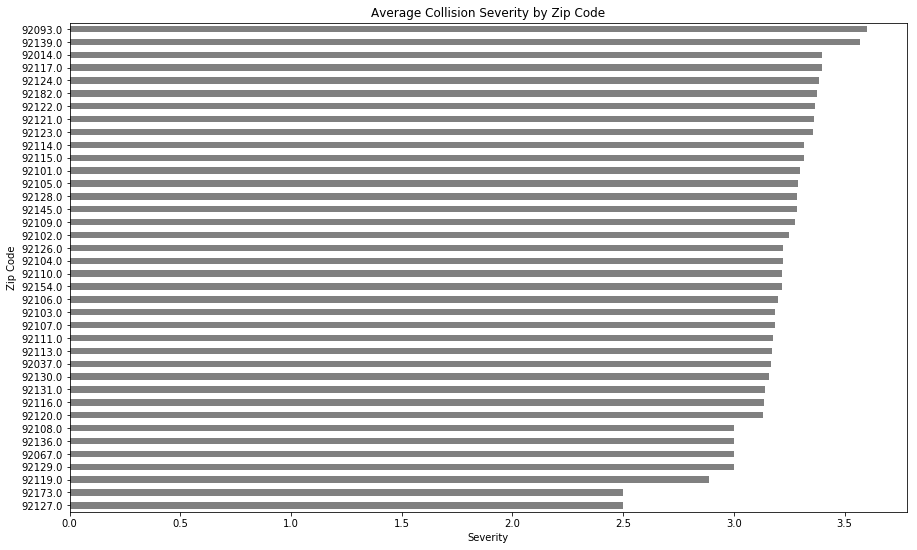

In [15]:
# Average severity of every zip code
(
    collisions_sdf
    .groupby('ZIPCODE')['COLLISION_SEVERITY'].mean().sort_values()
    .plot(kind='Barh', figsize=(15, 9), color='gray')
)

plt.xlabel('Severity')
plt.ylabel('Zip Code')
plt.title('Average Collision Severity by Zip Code');

Clearly we can see that some zip codes have greater average severities than other. However, it must be noted that some zip codes have very view collisions so one collision can heavily skew its overall average.  Also, the fact that this data comes from San Diego City may bring higher counts to the zip codes exclusively within it.

Let's instead plot the averages for those with at least 20 collisions.

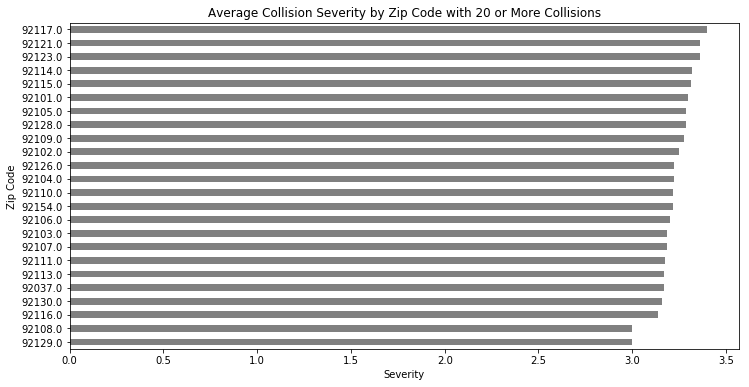

In [16]:
sizes = collisions_sdf.groupby('ZIPCODE')['COLLISION_SEVERITY'].size()
greater_20_index = sizes[sizes > 20].index
greater_20_df = collisions_sdf[collisions_sdf['ZIPCODE'].isin(greater_20_index)]
greater_20_df.groupby('ZIPCODE')['COLLISION_SEVERITY'].mean().sort_values().plot(kind='Barh', figsize=(12, 6), color='gray')

plt.xlabel('Severity')
plt.ylabel('Zip Code')
plt.title('Average Collision Severity by Zip Code with 20 or More Collisions');

We now have a more accurate representation of how the severity of collisions differs among zip codes. Overall, we can see that they all fall in the lower 3's which represents a visible injury.

Let's now break it down based on whether or not they are on bike paths. We will continue focusing on zip codes with at least 20 collisions.

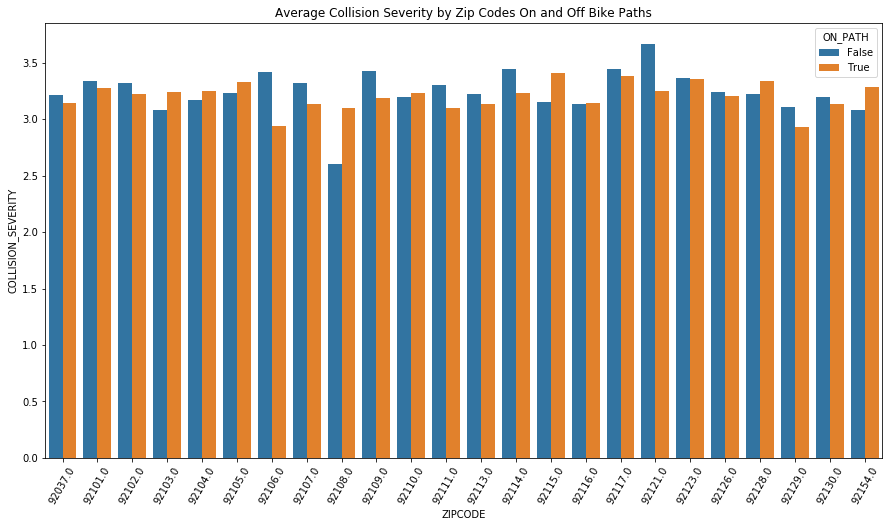

In [17]:
zip_path_rates = greater_20_df.groupby(['ON_PATH', 'ZIPCODE'])['COLLISION_SEVERITY'].mean()

plt.figure(figsize=(15,8))
sns.barplot(x='ZIPCODE', y='COLLISION_SEVERITY', hue='ON_PATH', data = zip_path_rates.reset_index())
plt.title('Average Collision Severity by Zip Codes On and Off Bike Paths')
plt.xticks(rotation=60);

It is quite difficult to tell visually if the differences are significant. In order to determine whether these distributions are different, we will be conducting a hypothesis test.  A paired, two-sample t-test will be used here, comparing the average collision severity of off-path versus on-path collisions, paired by zipcode.

$H_0: \mu_\text{off path} = \mu_\text{on path},\quad H_1: \mu_\text{off path} \neq \mu_\text{on path},\quad \alpha=0.05$

In [18]:
t_stat, p_value = scipy.stats.ttest_rel(zip_path_rates[True], zip_path_rates[False])
print(p_value)

0.3735379378808439


$p=0.37 \not< \alpha=0.05$, thus we fail to reject $H_0$.  We don't believe there is any significant difference in average collision severity between on-path versus off-path collisions.

Now we look at any difference by collision party combinations.

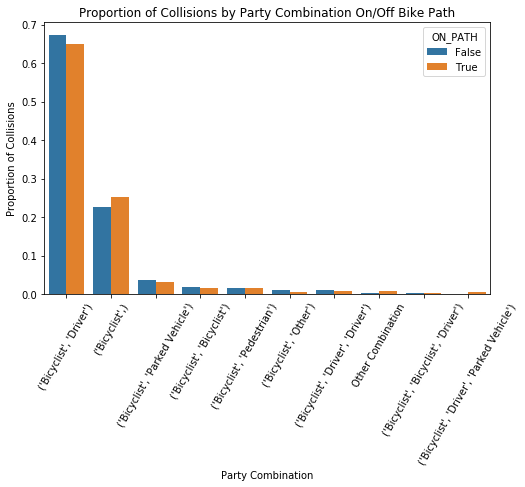

In [19]:
plt.figure(figsize=(8,5))
path_combos = map_sdf.groupby(['ON_PATH'])['PARTY_TYPE'].value_counts(normalize=True).rename(0)
sns.barplot(x='PARTY_TYPE', y=0, hue='ON_PATH', data = path_combos.reset_index())

plt.xlabel('Party Combination')
plt.ylabel('Proportion of Collisions')
plt.title('Proportion of Collisions by Party Combination On/Off Bike Path')
plt.xticks(rotation=60);

As we can see, the distributions of the other party on/off bike paths are very similar! The most common collision on/off a bike path occurs between the bicyclist and driver.

Although they are similar in this sense, let's see if there is a difference in the severities by each party category.

In [20]:
map_sdf.groupby("PARTY_TYPE")["COLLISION_SEVERITY"].mean()

PARTY_TYPE
('Bicyclist', 'Bicyclist')                   3.000000
('Bicyclist', 'Bicyclist', 'Driver')         3.000000
('Bicyclist', 'Driver')                      3.304589
('Bicyclist', 'Driver', 'Driver')            3.235294
('Bicyclist', 'Driver', 'Parked Vehicle')    3.000000
('Bicyclist', 'Other')                       3.333333
('Bicyclist', 'Parked Vehicle')              3.171875
('Bicyclist', 'Pedestrian')                  3.312500
('Bicyclist',)                               3.096360
Other Combination                            3.083333
Name: COLLISION_SEVERITY, dtype: float64

Based on the above, collisions involving more than one bicyclist seem associated with very slightly more severe injuries.  This could possibly be explained by there being twice as many people who are likely to be injured!  Overall, the differences in average severity are very slight, and not too much inference can be reliably ascertained.

Let's check if things change when we split up the data on whether or not they are on bike paths.

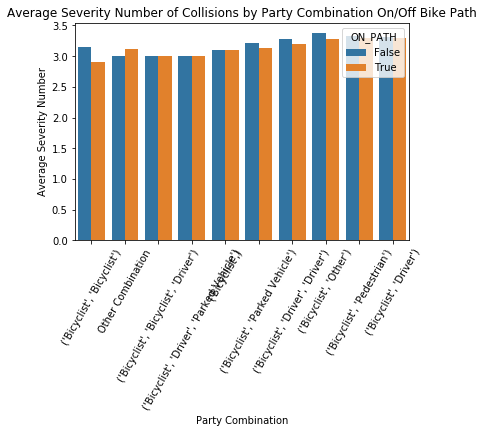

In [21]:
# Comparing average severity for different party types between off path and on path collisions.
grouped = map_sdf.groupby(['ON_PATH','PARTY_TYPE'])['COLLISION_SEVERITY'].mean().sort_values().rename(0)
sns.barplot(x="PARTY_TYPE", y=0, hue="ON_PATH", data=grouped.reset_index())

plt.xlabel('Party Combination')
plt.ylabel('Average Severity Number')
plt.title('Average Severity Number of Collisions by Party Combination On/Off Bike Path')
plt.xticks(rotation=60);

<a id="favorite-section"></a>

The average severity for every party combination dependent on bike paths don't show too much difference.

However, a large amount of the "bike paths" are really just large roads with bike lanes!

What are the differences in severity by route type?  If this is looks promising, then perhaps we can build a classifier for injury based on alcohol involved, route type, and party combination.  Route types are encoded as following:

* 0 - Off Path
* 1 - Multi-use Path
* 2 - Bike Lane
* 3 - Bike Route
* 6 - Freeway Shoulder Bike Access
* 8 - Other Suggested Route

In [22]:
collisions_sdf.assign(ROUTE=collisions_sdf.ROUTE.fillna(0)).groupby("ROUTE").COLLISION_SEVERITY.mean().sort_index()

ROUTE
0.0    3.250000
1.0    3.400000
2.0    3.233591
3.0    3.227397
6.0    3.250000
8.0    3.229452
Name: COLLISION_SEVERITY, dtype: float64

There's not a large difference between average severity for different routes either... but perhaps there is yet one more interesting calculation we can perform to try to answer whether you are more likely to be injured on versus off of a path.

What if we look at a frequentist likelihood of being injured on the different types of routes?

We can find a collision rate normalized by route as *"# of collisions per km of route infrastructure"*, and then we can compare these values for the different route type!

In [23]:
# NOTE: This cell will take ~1 minute to run, since we need to create study areas and enrich.

# Curious how many collisions happened on each route type.  Maybe we can also normalize by total length
# of each route type.

# Our bike routes feature layer will calculate a Shape__Length feature for us when we convert to a sdf.
# Note that this will be in epsg=3857, which is in meters!  Let's just convert to km.
meters_to_km = 1 / 1000
routes_sdf = bike_routes_fl.layers[0].query().sdf
route_lengths = routes_sdf.groupby("ROUTE").Shape__Length.sum() * meters_to_km

# But, we don't have any lengths for non-bike routes... sounds like the time for enrich!
#
# To find the "length" of off-path routes, we will:
# 1. Create a study area which encompasses all of our collisions.
# 2. Enrich the study area with road density
# 3. Subtract total bike route length from total road length.

# Let's enrich by zipcode, since we have a plan to use zipcode road density in the future.
#
# In order to enrich areas based on their zipcode, we must get the study area
# associated with each zipcode, then pass these in to be enriched.
zipcodes = collisions_sdf.ZIPCODE.unique().astype(int).astype(str).tolist()

# For some reason the geoquery field is incapable of handling a list!
# Thus, the following workaround is born.
zipstudies = pd.concat(map(
    lambda zipcode: standard_geography_query(
        source_country="US", layers=["US.ZIP5"], geoquery=zipcode, return_geometry=True
    ).iloc[[0]],
    zipcodes
))

# Can't convince arcgis to run enrich on the sdf either...
# So we need to run each one separately.
infrastructures = pd.concat(map(
    lambda studyrow: enrich(studyrow[1].to_frame().T, ["Infrastructure"]),
    zipstudies.iterrows()
))

# The roadsums are in km, just like our route lengths.
total_off_path_length = infrastructures.RoadSum.sum() - route_lengths.sum()

route_lengths[0] = total_off_path_length

# We are essentially calculating number of collisions per kilometer of route infrastructure, for each route type.
(
    collisions_sdf
    .assign(ROUTE=collisions_sdf.ROUTE.fillna(0))
    .groupby("ROUTE").CASE_ID.count().sort_index()
    / route_lengths
)

ROUTE
0.0    0.311415
1.0    0.071986
2.0    0.254515
3.0    0.561342
6.0    0.054508
8.0    0.495004
dtype: float64

If in fact you were more likely to be injured off of a bike path, then we would expect to see the number of injuries per roadway that is *not* a bike route to be the largest.  We didn't see any result that simple... but if we go a bit deeper, we did uncover some insights.

Here's what we uncovered:
- Being on a traditional bike path or other walking path without cars (labelled as 1 - Multi-use path) is likely the safest in terms of avoiding collisions (and thus—by our data—injuries, since all collisions resulted in an injury of some kind).
- Although the collision rate for 6 - Freeway Shoulder Bike Access is actually lower than Multi-use paths, this is likely because a) There are very few routes in this classification, and b) There are probably very few cyclists who would want to bike on the side of a freeway.  So, we are deciding to mostly ignore this type of route.
- The most dangerous routes are "3 - Bike Route" and "8 - Other Suggested Route".  This also makes sense because both of these classifications are used for roads that do not necessarily have a dedicated bike lane throughout (the road may be shared, or parking in the bike lane may be allowed).  Many streets in the city that have no bike lane whatsoever are classified as "Other Suggest Routes", and an example of a "Bike Route" would be the stretch of Gilman Drive between Meyers and Scholars where drivers need to share the road with cyclists because the bike lane has disappeared.  In these cases, the cyclist needs to ride on the same part of the road as the cars, so it's more likely that there will be collisions.
- While less safe than Multi-use paths, Bike Lanes have a relatively low collision rate.  Bike Lanes are indeed safer than cycling off of the paths entirely.
- Main takeaway: Cyclists are safest when there is a path or part of a path that is dedicated specifically for cycling, and much more collision-prone when they need to share a path with cars.

**In which parts of the city are you more likely to get into an accident with alcohol involved?**

In [121]:
# Let's create a heat map to get a feel for where alcohol-related accidents occur
map6 = gis.map("San Diego", zoomlevel=12)
map6.add_layer(collisions_fl, {"renderer":"HeatmapRenderer", "field_name":'ALCOHOL_INVOLVED'})
map6

MapView(layout=Layout(height='400px', width='100%'), zoom=12.0)

If we inspect the heat map carefully, we can see that these accidents occur predominently around famous attractions.

For example, at the zoom level specified, we see four main clusters. The densist being at the coast of the San Diego Harbor. This is the location where many of San Diego's biggest events occur such as Padres games at Petco Park, Comic-Con at the San Diego Convention Center, and even the Gas Lamp District.

We see the next cluster right around the North Park/Balboa Park Area. Through this area the San Diego Pride Festival happens every year. Also, this area is filled with housing and busy streets so we would expect a lot of bike use here and subsequently bike collisions.

We see the next two clusters surround the Mission Bay/Pacific Beach area and Old Town. These areas are popular tourist destinations.

Clearly we can see that alcohol related bike incidents occur in areas where people are likely to find amusement and consume alcohol in San Diego. This comes at no surprise!


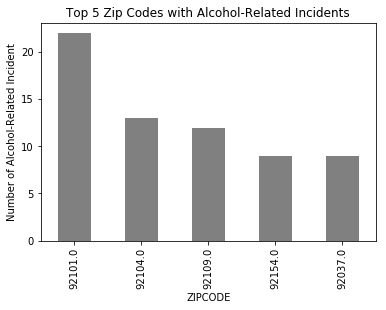

In [24]:
# Now we know the general areas of the collisions, lets figure out the zip codes!
top_5 = (
    collisions_sdf
    .assign(ALCOHOL_INVOLVED=collisions_sdf.ALCOHOL_INVOLVED.replace({'':False,'Y':True}))
    .groupby('ZIPCODE')['ALCOHOL_INVOLVED']
    .sum().sort_values(ascending=False)
    .iloc[:5]
)
top_5.plot(kind='bar', color='gray')

plt.title('Top 5 Zip Codes with Alcohol-Related Incidents')
plt.ylabel('Number of Alcohol-Related Incident');

In [123]:
# Lets plot these zip codes on a map!
map7 = gis.map('San Diego', zoomlevel=10)

zips = zip_codes.query().sdf
zips = zips[zips['ZIP'].isin(top_5.index)]
zips.spatial.plot(map_widget=map7)

map7

MapView(layout=Layout(height='400px', width='100%'), zoom=10.0)

The top 5 zip codes make up over a third of all alcohol-related incidents! Based on what's above, the greatest number of incidents occur within the 92101 zip code, more than one tenth of all incidents in San Diego City occur here (there are 39 zipcodes in our dataset).  This is the zipcode which we previously believed to be the most dangerous based on the heat map.

It appears that one is more likely to get into a bike-related accident in the 92109, 92101, 92154, 92104, and 92037 zip codes. Please note that we are making this conclusion based on the sheer number of incidents. We do not know how many bikers were going through the area so we are unable to calculate a rate for each zip code.

However, just as before, perhaps we can get a better idea of the danger level in different zipcodes by enriching.

If we enrich each zipcode to find the number of commuters that ride a bike to work, then we can control for this when counting collisions.

Note that this isn't a perfect estimate for the number of cyclists that pass through each zipcode, because cyclists could be commuting from one zipcode to another zipcode (or not even commuting at all), however it will be interesting to see how/if our results change when we normalize using this estimate.

In [25]:
# Just as before, let's enrich our zipcodes.
commutes = pd.concat(map(
    lambda studyrow: enrich(studyrow[1].to_frame().T, ["Commute"]),
    zipstudies.iterrows()
))

# We can find the number of bicycle commuters in each zip as the ACSBICYCLE field.
# And we can normalize the number of alcohol-related collisions in each zipcode by
# that number of commuters.
commutes = commutes.assign(AreaID = commutes.AreaID.astype(float))

(
    collisions_sdf
    .assign(ALCOHOL_INVOLVED=collisions_sdf.ALCOHOL_INVOLVED.replace({'':False,'Y':True}))
    .groupby('ZIPCODE')['ALCOHOL_INVOLVED'].sum()
    / commutes.groupby("AreaID").ACSBICYCLE.sum()
).sort_values(ascending=False).loc[lambda ser: (ser > 0) & (ser < np.inf)].iloc[:5]

92114.0    0.300000
92108.0    0.285714
92154.0    0.147541
92111.0    0.142857
92131.0    0.111111
dtype: float64

This estimate is not a good idea after all. (Although zipcode 92154 does show up again...)

For the reasons mentioned above—there are cyclists other than commuters and commuters don't remain in the same zipcode as they live—the rankings of the alcohol-related collision rates are determined almost entirely by the estimate for bicycle commuters.  All of the top 5 alcohol-related collision rates show above come from zipcodes with very few bicycle commuters.

If we try normalizing the total number of collisions instead of just alcohol-related collisions, we find in many of the top 5 zipcodes there are actually more collisions than commuters!  So, although this attempt was fun, the estimate is not good enough to produce worthwhile insights.

In [26]:
(
    collisions_sdf
    .groupby('ZIPCODE').CASE_ID.count()
    / commutes.groupby("AreaID").ACSBICYCLE.sum()
).sort_values(ascending=False).loc[lambda ser: (ser > 0) & (ser < np.inf)].iloc[:5]

92114.0    2.200000
92108.0    1.857143
92154.0    1.196721
92111.0    1.040816
92110.0    0.820000
dtype: float64

### Creating a predictor for collision severity using collision features and victim features

We want to train a model to predict collision severity, using fields that might be easily reported via an initial report of the collision.  This includes:
- Route, Party Combination, Number of Victims, Min and Max Age of Victims, and (possibly, though in reality unlikely) Alcohol Involved and Bike Impaired

In [27]:
df = (
    pd.merge(
        collisions[["CASE_ID"]], map_sdf[["CASE_ID", "COLLISION_SEVERITY", "ROUTE", "PARTY_TYPE", "ALCOHOL_INVOLVED", "BIKE_IMPAIRED"]],
        on="CASE_ID", how="inner"
    )
    # The only column with nulls so far is "ROUTE", which occurs when a collision was off-path.
    .fillna(0.0)
    # We need to get the number of victims and min/max age using the victim data grouped by case_id
    .set_index("CASE_ID")
    .assign(
        NUM_VICTIMS=victims.groupby("CASE_ID").PARTY_NUMBER.size(),
        MIN_AGE=victims.groupby("CASE_ID").VICTIM_AGE.min(),
        MAX_AGE=victims.groupby("CASE_ID").VICTIM_AGE.max(),
    )
)

df.head()

,COLLISION_SEVERITY,ROUTE,PARTY_TYPE,ALCOHOL_INVOLVED,BIKE_IMPAIRED,NUM_VICTIMS,MIN_AGE,MAX_AGE
CASE_ID,,,,,,,,
90581634,3,0.0,"('Bicyclist',)",False,False,1,65,65
90410428,4,0.0,"('Bicyclist', 'Driver')",False,False,1,49,49
90027314,3,0.0,"('Bicyclist',)",False,False,1,53,53
90196205,4,2.0,"('Bicyclist', 'Driver')",False,False,3,9,12
90124838,2,0.0,"('Bicyclist', 'Driver')",True,False,1,28,28


In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [61]:
X = df.drop("COLLISION_SEVERITY", axis=1)
y = df.COLLISION_SEVERITY

X_train, X_test, y_train, y_test = train_test_split(X, y)

pl = Pipeline([
    ("pre", ColumnTransformer([
        ("party_type", OrdinalEncoder(categories=[X.PARTY_TYPE.unique()]), ["PARTY_TYPE"]),
        ("boolean-string", OrdinalEncoder(categories=[X.ALCOHOL_INVOLVED.unique(), X.BIKE_IMPAIRED.unique()]), ["ALCOHOL_INVOLVED", "BIKE_IMPAIRED"])
    ], remainder="passthrough")),
    ("clf", RandomForestClassifier(100))
])


pl.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('pre', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('party_type', OrdinalEncoder(categories=[array(["('Bicyclist',)", "('Bicyclist', 'Driver')",
       "('Bicyclist', 'Parked Vehicle')", 'Other Combin...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [62]:
pl.score(X_test, y_test)

0.5604166666666667

At first, seeing an accuracy of ~56% seemed good since there are four labels that appear!  However, we then realized that the classifier would have performed better by just guessing '3' every time.  Comparing the predictions to the true values, we saw no evidence that the random forest was able to uncover what makes a very severe collision so severe, or a non-serious collision non-serious—our classifier was likely overwhelmed by the number of '3's in the dataset.

Because the more severe collisions are so rare, we should likely use a regression model that is built to handle rare events.  We do not know of such models yet.  Additionally, when all is said and done joining our ~2700 victim rows to their collisions and making sure we have a location so that we can say whether or not the collision was on a path, we only have 1920 collisions to train on.  Perhaps we might see our predictions improve if we were to run this project on the larger dataset.  However, we noticed that in some cases there are two parties involved, but there is only data present for one of them, and in many cases there is no victim data available—this is a large reason for our small data size!